In [1]:
import sys
import os
sys.path.append(os.path.abspath('..')) 

from deepkoop_func import Lusch
from deepkoop_func import koopman_loss, prediction_loss, get_device
from deepkoop_func import prepare_dataloader, create_sequences
from pysr import PySRRegressor
from deepkoop_func import eq_coarse_grain
from tools.tools import get_positive_contributions, compute_entropy
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import os
import random
from torch.utils.data import DataLoader, TensorDataset, random_split
import warnings
from sklearn.exceptions import ConvergenceWarning

# 过滤掉 sklearn 的收敛警告
warnings.filterwarnings("ignore", category=ConvergenceWarning)


def seed_everything(seed=42):
    """
    固定所有随机种子以确保结果可复现
    """
    # 1. Python 内置随机模块
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed) # 禁止hash随机化

    # 2. Numpy
    np.random.seed(seed)

    # 3. PyTorch
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

    # 4. 确保算法的确定性 (CUDNN)
    # 这两行会牺牲一点点性能，但能确保卷积操作的可复现性
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

/opt/anaconda3/envs/py311/lib/python3.11/site-packages/juliacall/__init__.py:61: UserWarning: torch was imported before juliacall. This may cause a segfault. To avoid this, import juliacall before importing torch. For updates, see https://github.com/pytorch/pytorch/issues/78829.
  warnings.warn(


Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython


# 数据处理

In [53]:
# 设置参数
LAMBDA = 0.8
MU = 10
BATCH_SIZE = 64

# --- 训练配置 ---
Sp = 30       # 训练时模型看多长？(预测步数)
seq_len_train = Sp + 1 # 实际切片长度需要多1个作为起始点

# --- 样本量配置 ---
# 为了让MLP拟合好，我们需要覆盖足够多的状态空间转换。
# 生成 100 条，每条 200 步的轨迹用于切片训练
N_TRAIN_TRAJS = 100
LEN_TRAIN_TRAJS = 100 

# 生成测试数据：需要更长的序列来验证长期稳定性
# 比如测试时想看 100 步的预测效果
STEP_TEST = 30 
N_TEST_TRAJS = 20     
LEN_TEST_TRAJS = STEP_TEST + 50 # 原始数据比测试步数稍微长一点，留有余地

训练集数据形状 (Trajs, Time, Dim): (100, 100, 2)
测试集数据形状 (Trajs, Time, Dim): (20, 100, 2)
------------------------------
转换后的 MLP 训练数据:
X_train: (9900, 2)
Y_train: (9900, 2)
------------------------------


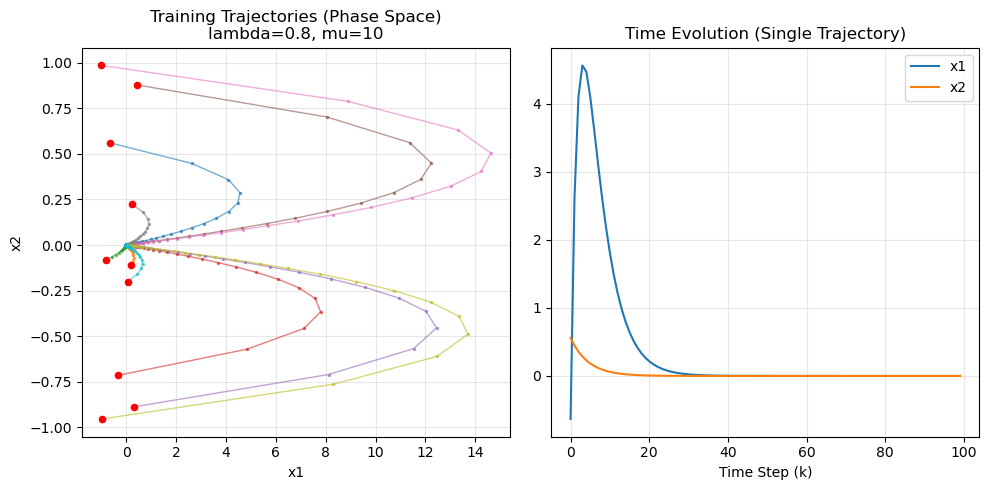

In [54]:
# def system_dynamics(state, lam=0.9, mu=0.5):
#     """单步动力学演化"""
#     x1, x2 = state[0], state[1]
#     y1 = lam * x1
#     y2 = mu * x2 + (lam**2 - mu) * (x1**2)
#     return np.array([y1, y2])

def system_dynamics(state, lam=0.8, mu=10):
    """单步动力学演化"""
    x1, x2 = state[0], state[1]
    y1 = lam * x1 + mu * (x2**2)
    y2 = lam * x2 
    return np.array([y1, y2])

def generate_trajectories(num_trajectories, steps_per_traj, lam=0.9, mu=0.5, init_range=(-1, 1)):
    """
    生成多条长轨迹
    返回数据形状: (num_trajectories, steps_per_traj, 2)
    """
    # 预分配空间
    # 形状: [轨迹数, 时间步数, 状态维度]
    dataset = np.zeros((num_trajectories, steps_per_traj, 2))
    
    for i in range(num_trajectories):
        # 随机初始化起始点 x0
        current_state = np.random.uniform(init_range[0], init_range[1], 2)
        dataset[i, 0, :] = current_state
        
        # 迭代生成后续步
        for t in range(1, steps_per_traj):
            next_state = system_dynamics(current_state, lam, mu)
            dataset[i, t, :] = next_state
            current_state = next_state
            
    return dataset


train_trajectories = generate_trajectories(N_TRAIN_TRAJS, LEN_TRAIN_TRAJS, lam=LAMBDA, mu=MU)


test_trajectories = generate_trajectories(N_TEST_TRAJS, LEN_TRAIN_TRAJS, lam=LAMBDA, mu=MU)

print(f"训练集数据形状 (Trajs, Time, Dim): {train_trajectories.shape}") # (50, 200, 2)
print(f"测试集数据形状 (Trajs, Time, Dim): {test_trajectories.shape}")   # (10, 200, 2)

# --- 3. 数据转换 (为 MLP 训练做准备) ---
# MLP 通常需要 (x_t) -> (x_t+1) 的形式，或者滑动窗口 (x_t, x_t-1...) -> (x_t+1)
# 这里演示最简单的单步输入输出转换，将所有轨迹打平
def create_mlp_dataset(trajectories):
    X_list = []
    Y_list = []
    
    num_trajs, time_steps, dim = trajectories.shape
    
    for i in range(num_trajs):
        # 输入：从 t=0 到 t=T-1
        # 输出：从 t=1 到 t=T
        traj = trajectories[i]
        X_list.append(traj[:-1, :]) # Current state
        Y_list.append(traj[1:, :])  # Next state
        
    X_data = np.vstack(X_list)
    Y_data = np.vstack(Y_list)
    return X_data, Y_data

X_train, Y_train = create_mlp_dataset(train_trajectories)
X_test, Y_test = create_mlp_dataset(test_trajectories)

print("-" * 30)
print("转换后的 MLP 训练数据:")
print(f"X_train: {X_train.shape}") # 应为 (50 * 199, 2) = (9950, 2)
print(f"Y_train: {Y_train.shape}")
print("-" * 30)

# --- 可视化 ---
# 画出部分训练轨迹（相图 Phase Portrait）
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
# 画前 10 条训练轨迹
for i in range(10):
    traj = train_trajectories[i]
    plt.plot(traj[:, 0], traj[:, 1], '.-', alpha=0.6, linewidth=1, markersize=3)
    # 标记起点
    plt.scatter(traj[0, 0], traj[0, 1], c='red', s=20, zorder=5)

plt.title(f"Training Trajectories (Phase Space)\nlambda={LAMBDA}, mu={MU}")
plt.xlabel("x1")
plt.ylabel("x2")
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
# 画第一条轨迹的时间演化 x1(t) 和 x2(t)
t_axis = np.arange(LEN_TRAIN_TRAJS)
plt.plot(t_axis, train_trajectories[0, :, 0], label='x1')
plt.plot(t_axis, train_trajectories[0, :, 1], label='x2')
plt.title("Time Evolution (Single Trajectory)")
plt.xlabel("Time Step (k)")
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [55]:
def generate_long_trajectories(num_trajs, steps, lam=0.9, mu=0.5, init_range=(-1, 1)):
    """生成 num_trajs 条长度为 steps 的原始长轨迹"""
    # shape: [num_trajs, steps, 2]
    data = np.zeros((num_trajs, steps, 2))
    
    for i in range(num_trajs):
        state = np.random.uniform(init_range[0], init_range[1], 2)
        data[i, 0, :] = state
        for t in range(1, steps):
            state = system_dynamics(state, lam, mu)
            data[i, t, :] = state
    return data

def create_sequences(data, seq_length):
    """
    将长轨迹切片成短序列。
    输入 data: [num_trajs, total_steps, feature_dim]
    输出 sequences: [total_samples, seq_length, feature_dim]
    
    逻辑：在每条长轨迹上滑动窗口
    """
    xs = []
    num_trajs, total_steps, dim = data.shape
    
    # 在每条轨迹上滑动
    # 假设 total_steps=100, seq_length=31 (输入1+预测30), 
    # 我们可以切出 (100 - 31 + 1) 个样本
    for i in range(num_trajs):
        traj = data[i]
        for j in range(total_steps - seq_length + 1):
            # 提取长度为 seq_length 的片段
            chunk = traj[j : j + seq_length, :]
            xs.append(chunk)
            
    return np.array(xs)

def prepare_dataloader(x_raw, T, batch_size=64, val_split=0.2):
    """
    准备训练和验证 DataLoader
    x_raw: 原始长轨迹数据 [num_trajs, total_steps, dim]
    T: 预测步数 (比如 30)。实际切片长度为 T+1 (包含 t0)
    """
    # 1. 切片
    # 我们需要长度为 T+1 的序列：
    # Input: seq[0] (或者 seq[0:T] 取决于你的模型结构)
    # Target: seq[1:T+1]
    seq_length = T + 1
    sequences = create_sequences(x_raw, seq_length)
    
    # 转换为 Tensor
    tensor_x = torch.FloatTensor(sequences) # shape: [N, T+1, 2]
    
    dataset = TensorDataset(tensor_x)
    
    # 3. 划分 Train/Val
    val_size = int(len(dataset) * val_split)
    train_size = len(dataset) - val_size
    train_ds, val_ds = random_split(dataset, [train_size, val_size])
    
    # 4. 创建 Loader
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False)
    
    return train_loader, val_loader

seed_everything(42)
# 1. 生成原始数据
print("生成原始轨迹数据...")
raw_train_data = generate_long_trajectories(N_TRAIN_TRAJS, LEN_TRAIN_TRAJS, LAMBDA, MU)
raw_test_data = generate_long_trajectories(N_TEST_TRAJS, LEN_TEST_TRAJS, LAMBDA, MU, init_range=(-0.8, 0.8)) # 测试集可以用稍微不同的范围或者相同范围

# 2. 准备 Dataloader (训练集处理)
# 这里的 T 对应你需要预测的步数
print(f"构建 DataLoader (T={Sp})...")
train_loader, val_loader = prepare_dataloader(raw_train_data, T=Sp, batch_size=BATCH_SIZE)

# 3. 准备测试集 (按照你的截图逻辑)
print(f"处理测试集 (Step_test={STEP_TEST})...")

x_test_dims = create_sequences(raw_test_data, STEP_TEST + 1)
X_test_recon = x_test_dims[:, :-STEP_TEST, :]   # Shape: [N, 1, 2] -> 起始点 x0
X_forecast_test = x_test_dims[:, -STEP_TEST:, :] # Shape: [N, STEP_TEST, 2] -> 真实未来 x1...xT

# 转换为 Tensor 方便后续使用
X_test_recon = torch.FloatTensor(X_test_recon)
X_forecast_test = torch.FloatTensor(X_forecast_test)

print("-" * 40)
print(f"Train Loader batches: {len(train_loader)}")
print(f"Val Loader batches:   {len(val_loader)}")
# 检查一个 Batch
for batch in train_loader:
    # batch[0] shape: [Batch_size, T+1, Dim]
    print(f"Train Batch Shape:    {batch[0].shape} (Batch, T+1, Dim)")
    break

print("-" * 40)
print(f"x_test_dims Shape:    {x_test_dims.shape}")
print(f"X_test_recon (Input): {X_test_recon.shape}  <- 起始点 x0")
print(f"X_forecast_test (GT): {X_forecast_test.shape}  <- 未来 {STEP_TEST} 步的真值")
print("-" * 40)


生成原始轨迹数据...
构建 DataLoader (T=30)...
处理测试集 (Step_test=30)...
----------------------------------------
Train Loader batches: 88
Val Loader batches:   22
Train Batch Shape:    torch.Size([64, 31, 2]) (Batch, T+1, Dim)
----------------------------------------
x_test_dims Shape:    (1000, 31, 2)
X_test_recon (Input): torch.Size([1000, 1, 2])  <- 起始点 x0
X_forecast_test (GT): torch.Size([1000, 30, 2])  <- 未来 30 步的真值
----------------------------------------


# 训练神经网络

In [56]:
koopman_dim = 3
# encoder dim
hidden_dim = 16
input_dim = 2

epochs = 10
lr = 1e-3
Sp = 30
# 宏观上多步预测误差默认是1
alpha1 = 2 #重构和微观预测误差
alpha2 = 1e-8  #无穷范数误差，去离群点
alpha3 = 1e-2  #正则项误差
alpha_CE = 0.01   #平均维度因果强度最大化
device = get_device(force_cpu=False)

device

device(type='mps')

  0%|          | 0/88 [00:00<?, ?it/s]/opt/anaconda3/envs/py311/lib/python3.11/site-packages/torch/autograd/graph.py:744: UserWarning: aten::linalg_svd: an autograd kernel was not registered to the Autograd key(s) but we are trying to backprop through it. This may lead to silently incorrect behavior. This behavior is deprecated and will be removed in a future version of PyTorch. If your operator is differentiable, please ensure you have registered an autograd kernel to the correct Autograd key (e.g. DispatchKey::Autograd, DispatchKey::CompositeImplicitAutograd). If your operator is not differentiable, or to squash this warning and use the previous behavior, please register torch::CppFunction::makeFallthrough() to DispatchKey::Autograd. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1716905753263/work/torch/csrc/autograd/autograd_not_implemented_fallback.cpp:72.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backw


 ==========  EPOCH 0  ==========

Prediction Loss: 0.1577
TRAIN LOSS:  1.2237347631969235
TEST LOSS:  0.9327810562469743
pred LOSS:  0.28154539520090277
reconstruction LOSS:  0.11065087789161639
lin LOSS:  0.13681829094209455
inf LOSS:  1.1356207863851027
ce LOSS:  -1.2425786256790161


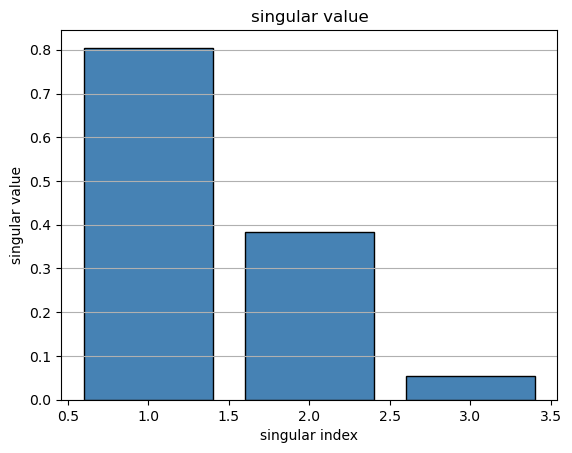

100%|██████████| 22/22 [00:00<00:00, 110.91it/s]



 ==========  EPOCH 2  ==========

Prediction Loss: 0.0501
TRAIN LOSS:  0.31577705132605677
TEST LOSS:  0.18561377545649355
pred LOSS:  0.0806202001192353
reconstruction LOSS:  0.0013899517282631925
lin LOSS:  0.012137538557660511
inf LOSS:  0.256249836222692
ce LOSS:  -1.9631634950637817


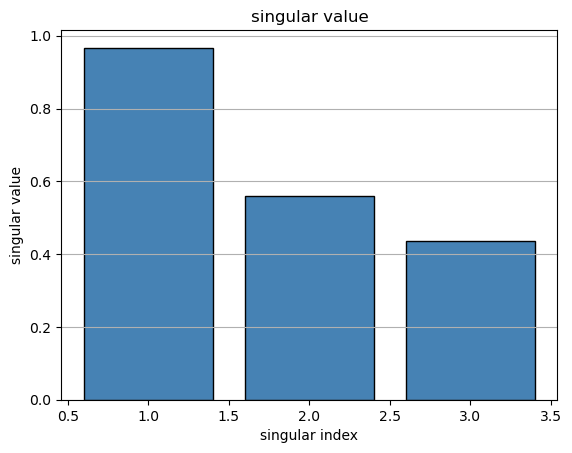

100%|██████████| 22/22 [00:00<00:00, 110.77it/s]



 ==========  EPOCH 4  ==========

Prediction Loss: 0.0473
TRAIN LOSS:  0.20070997621356088
TEST LOSS:  0.17108509909700265
pred LOSS:  0.07579023003662852
reconstruction LOSS:  0.0010149656895505773
lin LOSS:  0.008389655431859534
inf LOSS:  0.2308713888580149
ce LOSS:  -1.9440150260925293


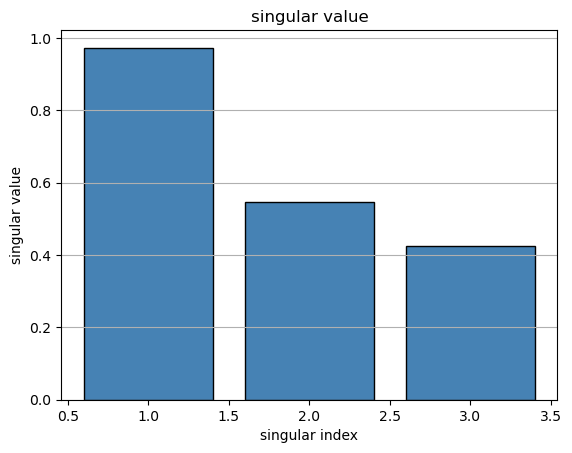

100%|██████████| 22/22 [00:00<00:00, 111.68it/s]



 ==========  EPOCH 6  ==========

Prediction Loss: 0.0422
TRAIN LOSS:  0.18283291812986135
TEST LOSS:  0.14971146190708334
pred LOSS:  0.06636310459791937
reconstruction LOSS:  0.001460135946134952
lin LOSS:  0.005313508840944533
inf LOSS:  0.22478856112469325
ce LOSS:  -1.921051025390625


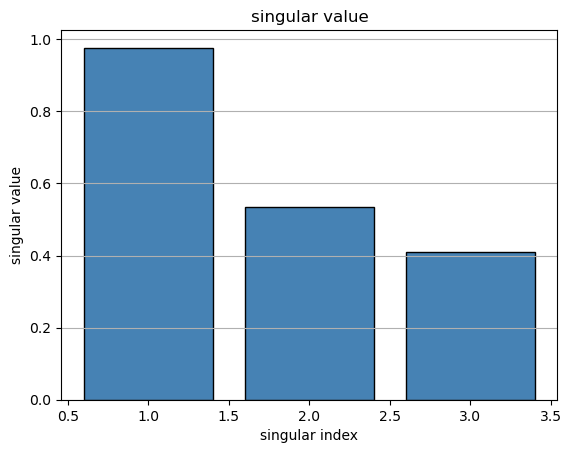

100%|██████████| 22/22 [00:00<00:00, 113.08it/s]



 ==========  EPOCH 8  ==========

Prediction Loss: 0.0328
TRAIN LOSS:  0.1489228893664073
TEST LOSS:  0.11881068094887516
pred LOSS:  0.04866594986312769
reconstruction LOSS:  0.005392744605408304
lin LOSS:  0.0022140959421945313
inf LOSS:  0.26660197228193283
ce LOSS:  -1.9074454307556152


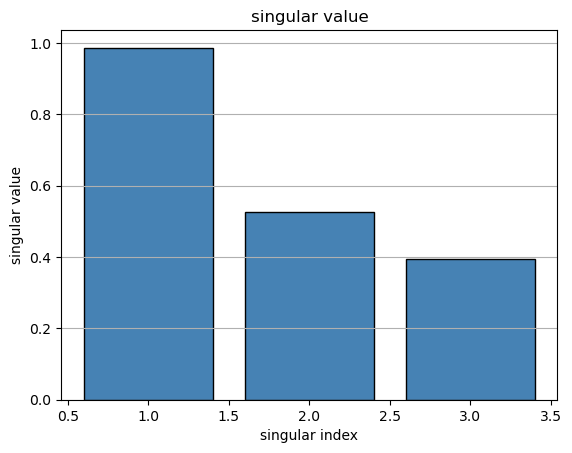

100%|██████████| 22/22 [00:00<00:00, 111.73it/s]


In [57]:
seed_everything(42)
model = Lusch(input_dim,koopman_dim,hidden_dim = hidden_dim, device=device).to(device=device)
optimizer = torch.optim.Adam(model.parameters(),lr=lr)

# model.mu = train_loader.dataset.mu.to(device)
# model.std = train_loader.dataset.std.to(device)
train_losses = []; test_losses = []; pred_losses = []; reconstruction_losses = []; lin_losses = []; inf_losses = []; ce_losses = []
for epoch in range(0, epochs):
    train_epoch_loss = []
    test_epoch_loss = []
    pred_epoch_loss = []
    reconstruction_epoch_loss = []
    lin_epoch_loss = []
    inf_epoch_loss = []
    ce_epoch_loss = []

    model.train()
    for (x,) in tqdm(train_loader):
        optimizer.zero_grad()
        loss_train, _, _, _, _, _ = koopman_loss(x.to(device=device), model, Sp=Sp, alpha1=alpha1, alpha2=alpha2, alpha3=alpha3, alpha_CE=alpha_CE)
        loss_train.backward()
        optimizer.step()
        train_epoch_loss.append(loss_train.item())

    with torch.no_grad():
        model.eval()
        for (x,) in tqdm(val_loader):
            loss_test, pred_loss, reconstruction_loss, lin_loss, inf_loss, ce_loss = koopman_loss(x.to(device=device), model, Sp=Sp, alpha1=alpha1, alpha2=alpha2, alpha3=alpha3, alpha_CE=alpha_CE)
            test_epoch_loss.append(loss_test.cpu().item())
            pred_epoch_loss.append(pred_loss.cpu().item())
            reconstruction_epoch_loss.append(reconstruction_loss.cpu().item())
            lin_epoch_loss.append(lin_loss.cpu().item())
            inf_epoch_loss.append(inf_loss.cpu().item())
            ce_epoch_loss.append(ce_loss.cpu().item())

        forecast_loss = prediction_loss(X_test_recon[:,[-1],:].to(device=device), X_forecast_test.to(device=device), model)

    if epoch % 2 == 0:
        trainloss = np.sum(train_epoch_loss)/len(train_epoch_loss)
        testloss = np.sum(test_epoch_loss)/len(test_epoch_loss)
        predloss = np.sum(pred_epoch_loss)/len(pred_epoch_loss)
        reconloss = np.sum(reconstruction_epoch_loss)/len(reconstruction_epoch_loss)
        linloss = np.sum(lin_epoch_loss)/len(lin_epoch_loss)
        infloss = np.sum(inf_epoch_loss)/len(inf_epoch_loss)
        celoss = np.sum(ce_epoch_loss)/len(ce_epoch_loss)
        print("\n","="*10,f" EPOCH {epoch} ","="*10)
        print("\nPrediction Loss: {:.4f}".format(forecast_loss))
        # print("Reconstruction Loss: {:.4f}".format(reconstruction_loss))
        print("TRAIN LOSS: ", trainloss)
        print("TEST LOSS: ", testloss)
        print("pred LOSS: ", predloss)
        print("reconstruction LOSS: ", reconloss)
        print("lin LOSS: ", linloss)
        print("inf LOSS: ", infloss)
        print("ce LOSS: ", celoss)
        train_losses.append(trainloss)
        test_losses.append(testloss)
        pred_losses.append(predloss)
        reconstruction_losses.append(reconloss)
        lin_losses.append(linloss)
        inf_losses.append(infloss)
        ce_losses.append(celoss)

        K = model.koopman.linear_evolution.weight.cpu().data.numpy()
        U,S,V = np.linalg.svd(K)
        plt.figure()
        plt.bar(np.arange(1, len(S)+1), S, color='steelblue', edgecolor='k')
        plt.grid(True, axis='y')         
        plt.xlabel('singular index')
        plt.ylabel('singular value')
        plt.title('singular value')
        plt.show()

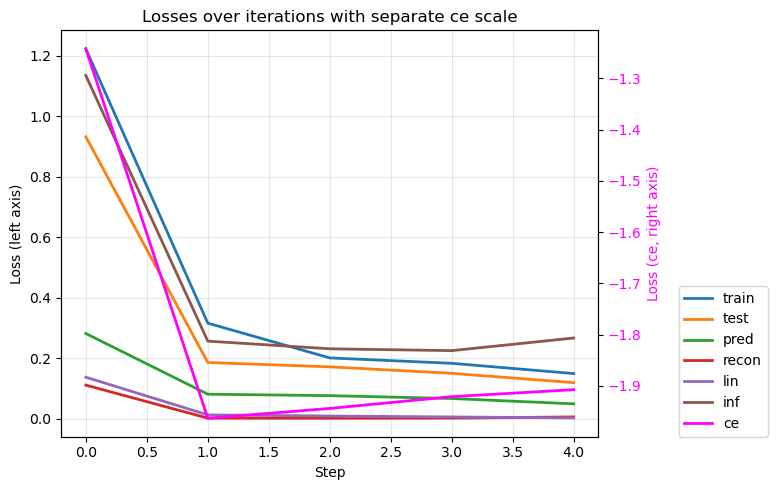

In [58]:
import numpy as np
import matplotlib.pyplot as plt

# 假设你已有以下列表
# train_losses, test_losses, pred_losses, reconstruction_losses, lin_losses, inf_losses, ce_losses

steps = np.arange(len(train_losses))  # 根据实际长度设置

fig, ax1 = plt.subplots(figsize=(8,5))

# 画左轴的曲线（不包含 ce）
left_curves = {
    'train': train_losses,
    'test': test_losses,
    'pred': pred_losses,
    'recon': reconstruction_losses,
    'lin': lin_losses,
    'inf': inf_losses,
}
colors = plt.cm.tab10(range(len(left_curves)))
for (name, arr), color in zip(left_curves.items(), colors):
    ax1.plot(steps, arr, label=name, color=color, linewidth=2)

ax1.set_xlabel('Step')
ax1.set_ylabel('Loss (left axis)')
ax1.grid(True, alpha=0.3)

# 右轴绘制 ce
ax2 = ax1.twinx()  # 创建共享 x 轴的第二坐标轴
ax2.plot(steps, ce_losses, color='magenta', label='ce', linewidth=2)
ax2.set_ylabel('Loss (ce, right axis)', color='magenta')
ax2.tick_params(axis='y', labelcolor='magenta')

# 图例：要把两侧图例合并为一个
lines_left, labels_left = ax1.get_legend_handles_labels()
lines_right, labels_right = ax2.get_legend_handles_labels()
ax1.legend(lines_left + lines_right, labels_left + labels_right, loc=[1.15,0], fontsize=10)

plt.title('Losses over iterations with separate ce scale')
plt.tight_layout()
plt.show()


In [8]:
save_path = "model_save/toy_ce0_seed42_sp30_l1.pth"
print(f"正在保存模型参数到 {save_path} ...")

# 核心代码：只保存 state_dict (参数字典)
torch.save(model.state_dict(), save_path)
print("保存成功！")

正在保存模型参数到 model_save/toy_ce0_seed42_sp30_l1.pth ...
保存成功！


In [8]:
import torch

# 1. 设置模型文件路径（需与保存时的路径一致）
load_path = "model_save/air127_ce005_type1.pth"

model = Lusch(input_dim,koopman_dim,hidden_dim = hidden_dim, device=device).to(device=device)

print(f"正在从 {load_path} 加载模型参数 ...")

try:
    # 3. 加载参数字典
    # map_location='cpu' 确保即使模型是在GPU上训练的，也能在没有GPU的机器上加载
    checkpoint = torch.load(load_path, map_location='cpu')
    
    # 4. 将参数加载到模型中
    # strict=True (默认) 会严格检查键值是否匹配，如果你的模型结构改了，这里会报错
    model.load_state_dict(checkpoint, strict=True)
    
    print("参数加载成功！")

    print("模型已切换至评估模式，可以进行预测了。")

except FileNotFoundError:
    print(f"错误：找不到文件 {load_path}，请检查路径。")
except RuntimeError as e:
    print(f"加载失败，通常是因为模型结构不匹配：\n{e}")

正在从 model_save/air127_ce005_type1.pth 加载模型参数 ...
参数加载成功！
模型已切换至评估模式，可以进行预测了。


In [60]:
model.eval()

seed_everything(0)
input_dim = 2
X_torch = torch.randn(100, input_dim, device=device)

# 4) 计算编码器输出作为符号回归的目标
with torch.no_grad():
    Y_torch = model.encoder(X_torch)  # shape (batch_size, 1)

X_np = X_torch.detach().cpu().numpy()          # shape (batch_size, input_dim)
Y_np = Y_torch.detach().cpu().numpy()

default_pysr_params = dict(
    populations=200,
    model_selection="best", #best, accuracy
    niterations=30, # 迭代次数越多越精确，但越慢
    binary_operators=["+", "-"],
    unary_operators=[
        "square"
    ],
    maxsize=7, # 限制公式复杂度
    temp_equation_file=False, 
    delete_tempfiles=True,
    verbosity=0,
    denoise=False,
    procs=4, # 并行核心数
)

encoder_eqs = []
latent_dim = Y_np.shape[1]

for i in range(latent_dim):
    print(f"--- Fitting Latent Dimension g_{i} ---")
    model_sr = PySRRegressor(**default_pysr_params)
    model_sr.fit(X_np, Y_np[:, i])
    
    eq = model_sr.sympy()
    encoder_eqs.append(eq)
    print(f"Y_{i} = {eq}")


--- Fitting Latent Dimension g_0 ---


/opt/anaconda3/envs/py311/lib/python3.11/site-packages/pysr/sr.py:2811: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(


Y_0 = -x1**2 + (x1 - 1*(-0.2823402))**2
--- Fitting Latent Dimension g_1 ---


/opt/anaconda3/envs/py311/lib/python3.11/site-packages/pysr/sr.py:2811: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(


Y_1 = x0 - (x0 - 1*35.402893) - 35.985157
--- Fitting Latent Dimension g_2 ---


/opt/anaconda3/envs/py311/lib/python3.11/site-packages/pysr/sr.py:2811: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(


Y_2 = -x1 + x1 - 1*(-0.7593384)


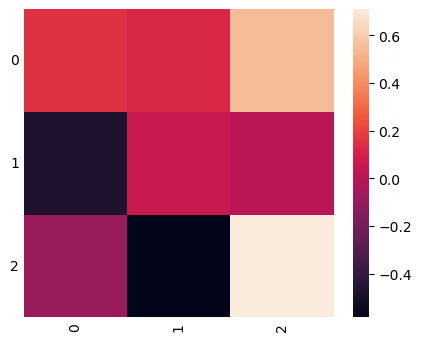

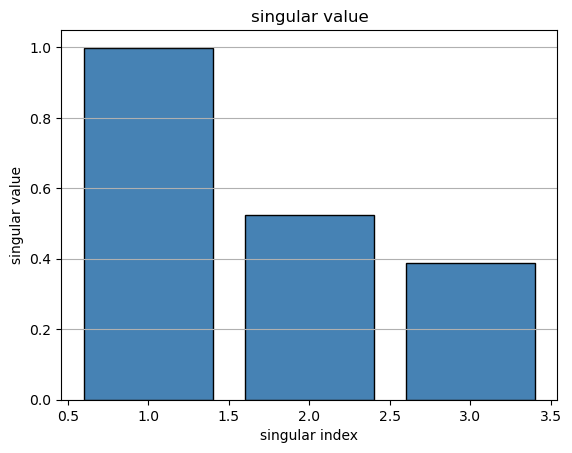

In [61]:
K = model.koopman.linear_evolution.weight.cpu().data.numpy()

# 只设置参数，不自动显示全部
plt.figure(figsize=(5, 4)) # 把画布搞大一点
plt.tick_params(axis='both', which='both', length=0)
_ = sns.heatmap(K)
# 旋转横轴标签，避免重叠
plt.xticks(rotation=90)  # 旋转90度
plt.yticks(rotation=0)   # 纵轴保持水平
plt.show()

U,S,V = np.linalg.svd(K)
plt.figure()
plt.bar(np.arange(1, len(S)+1), S, color='steelblue', edgecolor='k')
plt.grid(True, axis='y')         
plt.xlabel('singular index')
plt.ylabel('singular value')
plt.title('singular value')
plt.show()

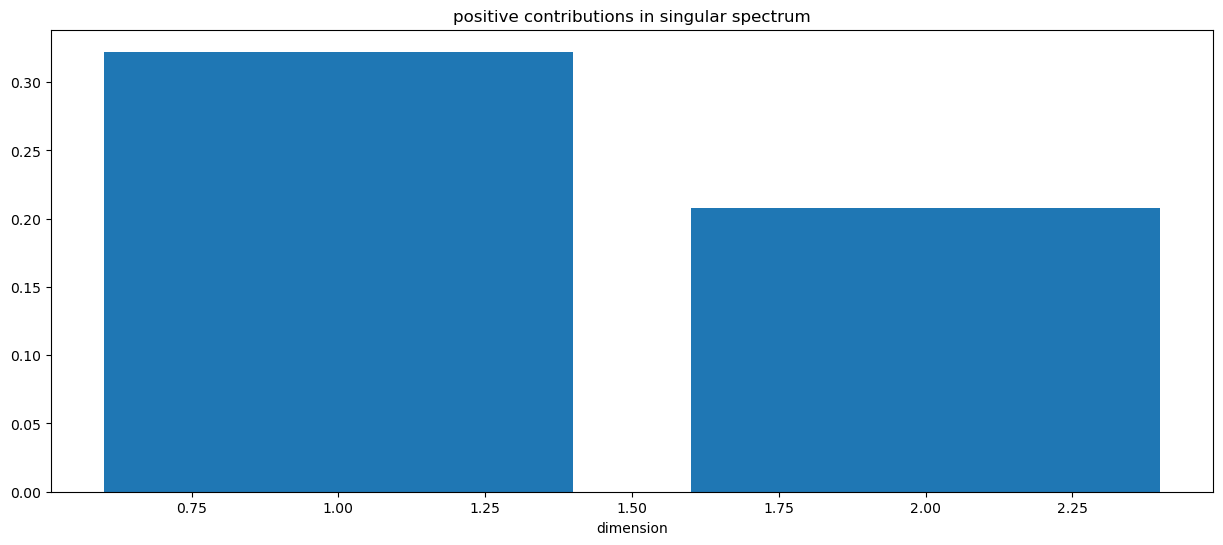

In [62]:
# 多尺度因果力分布
diff = get_positive_contributions(S)
#diff = diff[:50]
plt.figure(figsize=(15, 6))
plt.bar(range(1,len(diff)+1), diff) 
plt.xlabel('dimension')
plt.title('positive contributions in singular spectrum')
plt.show()

In [11]:
# 计算EC
print(compute_entropy(diff))

0.99801195


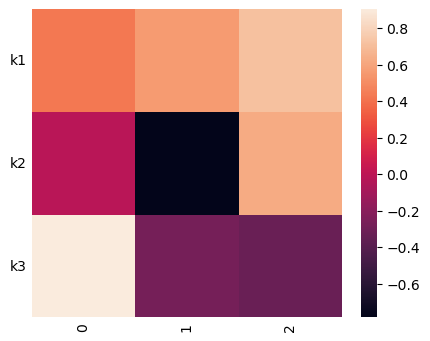

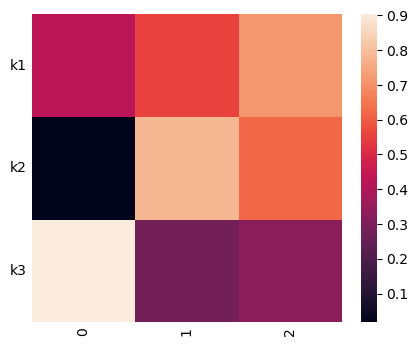

In [63]:
U_abs = np.abs(U)
new_names = ['k1', 'k2', 'k3']
plt.figure(figsize=(5, 4)) 
plt.tick_params(axis='both', which='both', length=0)
_ = sns.heatmap(U, yticklabels=new_names)
plt.xticks(rotation=90)  
plt.yticks(rotation=0)   
plt.show()


plt.figure(figsize=(5, 4)) 
plt.tick_params(axis='both', which='both', length=0)
_ = sns.heatmap(U_abs, yticklabels=new_names)
plt.xticks(rotation=90)  
plt.yticks(rotation=0)   
plt.show() 

In [64]:
rank = 3
coarse_grain_coff = U[:,:rank]
X_np, macro_data = eq_coarse_grain(model, train_loader, coarse_grain_coff, num_samples=200)
print(f"Sampled shapes: micro={X_np.shape}, macro={macro_data.shape}")

Sampled shapes: micro=(200, 2), macro=(200, 3)


In [65]:
encoder_eqs = []
latent_dim = macro_data.shape[1]

for i in range(latent_dim):
    print(f"--- Fitting Latent Dimension g_{i} ---")
    model_sr = PySRRegressor(**default_pysr_params)
    model_sr.fit(X_np, macro_data[:, i])
    
    eq = model_sr.sympy()
    encoder_eqs.append(eq)
    print(f"Y_{i} = {eq}")


--- Fitting Latent Dimension g_0 ---


/opt/anaconda3/envs/py311/lib/python3.11/site-packages/pysr/sr.py:2811: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(


Y_0 = -x0**2 + (x0 + 0.10688363)**2
--- Fitting Latent Dimension g_1 ---


/opt/anaconda3/envs/py311/lib/python3.11/site-packages/pysr/sr.py:2811: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(


Y_1 = -x0**2 + (x0 + 0.0321991)**2
--- Fitting Latent Dimension g_2 ---


/opt/anaconda3/envs/py311/lib/python3.11/site-packages/pysr/sr.py:2811: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(


Y_2 = -x0**2 + (0.022195356 - x0)**2


/var/folders/mw/53dhwskj4zq47dtls4lhht4m0000gn/T/ipykernel_30981/3211535169.py:13: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


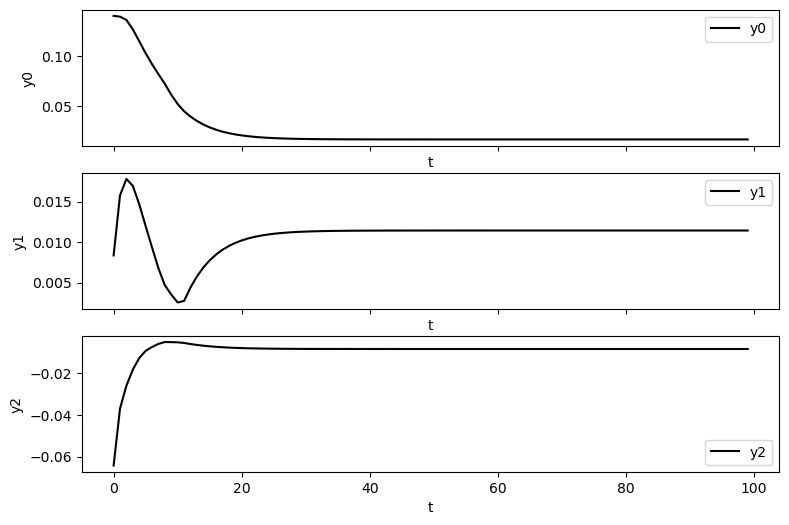

In [66]:
one_traj = generate_long_trajectories(1, 100, LAMBDA, MU, init_range=(-0.8, 0.8))
micro_data = torch.tensor(one_traj.reshape(-1,2), dtype=torch.float32, device=device)
g = model.encoder(micro_data)
macro_serie = g.cpu().detach().numpy() @ coarse_grain_coff

macro_dim = macro_serie.shape[1]

fig, axs = plt.subplots(macro_dim, 1, sharex=True, figsize=(9, 6))
for i in range(macro_dim):
    axs[i].plot(macro_serie[:, i], "k", label=f"y{i}")
    axs[i].legend()
    axs[i].set(xlabel="t", ylabel=f"y{i}")
fig.show()

In [36]:
print("\n[Encoder Functions]:")
variable_names_x = [f"x{i}" for i in range(X_np.shape[1])]
for i, eq in enumerate(encoder_eqs):
    print(f"Y[{i}] = {eq}")


[Encoder Functions]:
Y[0] = x1**2 - (x1 + 0.057068158)**2
Y[1] = x1**2 - (-x1 - 0.025981808)**2
Y[2] = -x1**2 + (x1 + 0.07953196)**2


In [11]:
print("\n[Encoder Functions]:")
variable_names_x = [f"x{i}" for i in range(X_np.shape[1])]
for i, eq in enumerate(encoder_eqs):
    print(f"Y[{i}] = {eq}")


[Encoder Functions]:
Y[0] = (2.0276968 + (x113/((x107/x99 - 0.4798503)**x85 + 1.5988652) + x13 + x67 - x88 + x99)*(-0.023124624))*(-2.2920766)
Y[1] = -0.020992607*x16/sqrt(x60) - 0.0351678333878395*x28 - 0.020992607*x3 - 0.0351678333878395*x42/sqrt(x57) + 0.0351678333878395*x52 + 0.0351678333878395*x79 - 0.0351678333878395*x86 + 0.3158994


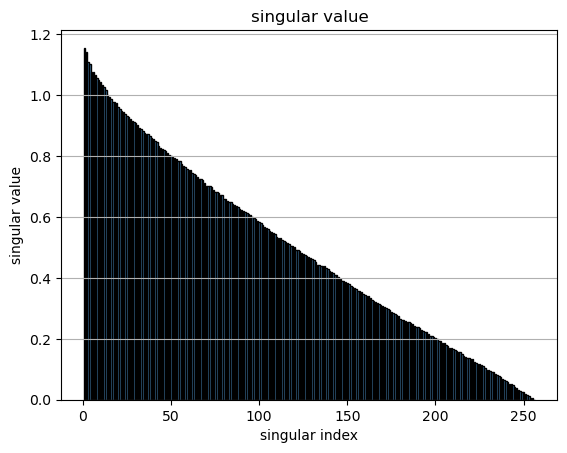

In [15]:
seed_everything(42)
model = Lusch(input_dim,koopman_dim,hidden_dim = hidden_dim, device=device).to(device=device)

K = model.koopman.linear_evolution.weight.cpu().data.numpy()
U,S,V = np.linalg.svd(K)
plt.figure()
plt.bar(np.arange(1, len(S)+1), S, color='steelblue', edgecolor='k')
plt.grid(True, axis='y')         
plt.xlabel('singular index')
plt.ylabel('singular value')
plt.title('singular value')
plt.show()

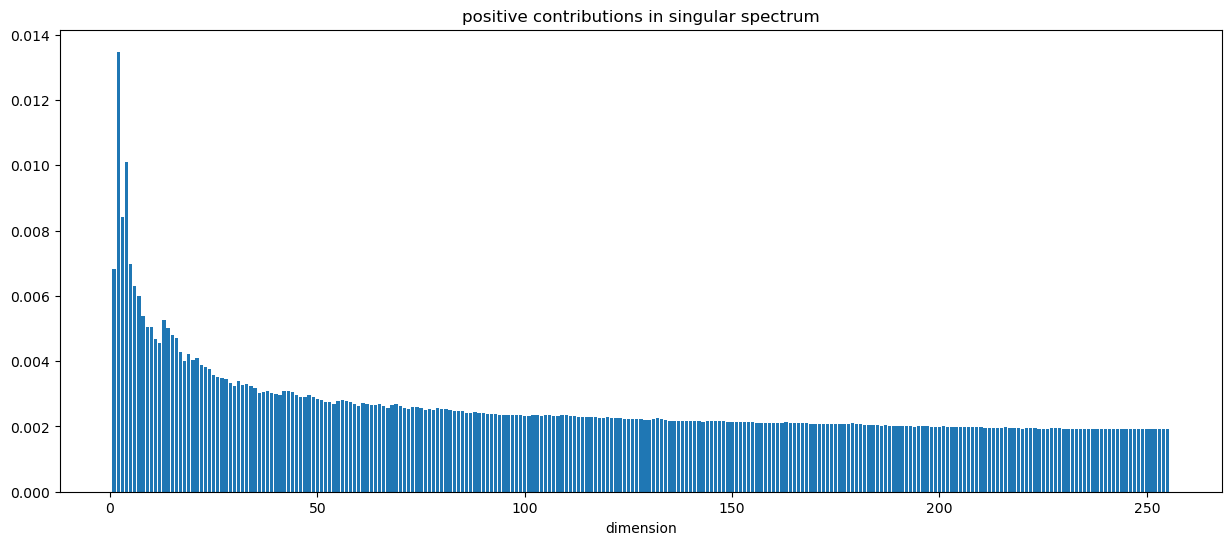

In [16]:
diff = get_positive_contributions(S)
plt.figure(figsize=(15, 6))
plt.bar(range(1,len(diff)+1), diff) 
plt.xlabel('dimension')
plt.title('positive contributions in singular spectrum')
plt.show()

In [17]:
print(compute_entropy(diff))

7.8833513
